<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone VI</font></h2>



<h1><font color="#00586D" size=5>Análisis de un problema de clasificación con deep learning</font></h1>
<br><br>

<div align="right">
<font color="#00586D" size=3>Fernando Rubio, Daniel González</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

In [1]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.metrics as confusion_matrix
from sklearn.model_selection import train_test_split
import autokeras as ak

**Nota**: en este notebook es esencial utilizar la GPU para entrenar nuestras redes. Recuerda realizar la instalación de las versiones adecuadas para poder utilizar la GPU usando el comando de la siguiente celda. Una vez instales las versiones adecuadas de tensorflow y autokeras debes reiniciar el **runtime** comprobando que has selecionado el uso de **GPU**:

In [4]:
!pip install --upgrade tensorflow==2.4.0 autokeras

     |████████████████████████████████| 394.7 MB 19 kB/s 
     |████████████████████████████████| 160 kB 44.5 MB/s 
     |████████████████████████████████| 462 kB 42.5 MB/s 
     |████████████████████████████████| 14.8 MB 34.6 MB/s 
     |████████████████████████████████| 2.9 MB 35.8 MB/s 
     |████████████████████████████████| 3.8 MB 35.1 MB/s 
     |████████████████████████████████| 132 kB 47.6 MB/s 
     |████████████████████████████████| 160 kB 47.0 MB/s 
     |████████████████████████████████| 166 kB 50.4 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=20f0bd8b941ca94e5948381c979c68659a6b3035b5520628e8a3849963998a04
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-ext

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Dataset](#section2)
* [3. Preprocesamiento de datos](#section3)
* [4. Ejemplo](#section4)
* [5. Creación de un modelo desde cero](#section5)
* [6. Ajuste de hiperparámetros](#section6)
* [7. Modelos pre-entrenados](#section7)
* [8. Data augmentation](#section8)
* [9. Autokeras](#section9)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section1"></a> 
## <font color="#00586D"> 1. Introducción</font>
<br>

El objetivo del Capstone es **simular un análisis completo de un problema de clasificación de imágenes usando Deep Learning**.

El análisis está compuesto de una serie de pasos que iremos viendo detenidamente uno por uno, que os puede servir de guía para seguir a la hora de resolver un problema con Deep Learning. Los **pasos** que vamos a seguir son los siguientes:

1. **Dataset**: Descarga y previsualización de los datos.
2. **Preprocesamiento de los datos**: prepararemos las imágenes para que puedan ser entrenadas.
3. **Modelo desde cero**: Creación de una red neuronal desde cero.
4. **Ajuste de hiperparámetros**: Mejora del modelo anterior mediante el ajuste de hiperparámetros.
5. **Modelos pre-entrenados (fine-tunning)**: Uso de técnicas de *Finetunning* sobre un modelo pre-entrenado.
6. **Data augmentation (Opcional)**: Uso de *data augmentation* en el dataset.
7. **Conclusión**: se deberá sacar unas conclusiones a partir de los resultados obtenidos, decidiendo cual de los modelos entrenados podríamos desplegar en producción para usarlo.

Los puntos a completar son del 3 al 7, en **cada punto se detalla exactamente qué se tiene que hacer**, es decir, habrá bloques de código en blanco y se detallará las arquitectura de las redes y la configuración de los entrenamientos, por lo que las redes a crear serán las indicadas en cada paso.

Al final de cada paso habrá que comentar los resultados obtendos en los entrenamientos, sacando **conclusiones de los experimentos** que vamos a llevar acabo, justificando y midiendo el rendimiento de los modelos obtenidos según las técnicas que utilicemos. La evaluación de los modelos se realizará en terminos de tasa de aciertos y la matriz de confusión de las clases.

_**Nota**: ejecuta el siguiente código para montar tu Drive y no perder los datos que vayamos a descargar. Además se hará un `cd` hacia el drive para guardar ahí todos los datos generados y descargados_

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section2"></a> 
## <font color="#00586D"> 2. Dataset</font>
<br>
El dataset utilizado está compuesto por imágenes de distintas razas de perro. El dataset contiene 12.891 imágenes con 74 razas, por lo tanto, el objetivo será crear y entrenar un módelo que clasifique la raza de un perro a partir de una imagen. Para descargar el dataset ejecuta la siguiente celda:

In [5]:
!wget 'https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1'
!mv 'ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1' dog-images.zip
!unzip -q dog-images.zip

--2022-02-26 10:53:11--  https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1
Resolving pruebasaluuclm-my.sharepoint.com (pruebasaluuclm-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to pruebasaluuclm-my.sharepoint.com (pruebasaluuclm-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/fernando_rubio_uclm_es/Documents/dog-dataset.zip [following]
--2022-02-26 10:53:13--  https://pruebasaluuclm-my.sharepoint.com/personal/fernando_rubio_uclm_es/Documents/dog-dataset.zip
Reusing existing connection to pruebasaluuclm-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 498626796 (476M) [application/x-zip-compressed]
Saving to: ‘ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1’

ESpljekZA9dAgxsfc3q 100%[===================>] 475.53M  56.4MB/s    in 15s     

2022-02-26 10:53:28 (31.7 MB/s) - ‘E

Se descargará un archivo `dog-images.zip` que se descomprimirá automáticamente creando la carpeta `dog-dataset` que contiene el dataset completo. La estructura de los ficheros descargados sera:

```
--> dog-images.zip
--> dog-dataset/
-->    test.csv
-->    train.csv
-->    valid.csv
-->    dog-images/
-->        Afghan_hound/
-->        African_hunting_dog/
-->        ...
```


En el interior de la carpeta `dog-dataset` se encuentrarn 3 ficheros *CSVs* y otra carpeta (`dog-images`):

* Carpeta `dog-images`: contiene todas las imágenes del dataset. Las imágenes están distribuidas por carpetas según las disintas razas (74 carpetas en total). El nombre de cada carpeta corresponde con la raza.
* `train.csv`: conjunto de datos para el entrenamiento, 8.992 imágenes. El fichero está en formato *CSV* y cada fila se corresponde con una imagen distinta. El *CSV* tiene 2 columnas, la columna *label* que corresponde a la clase (raza) y la columna *path* que correponde con la ruta donde está cada imagen en la carpeta `dog-images`.
* `valid.csv`: conjunto de datos para la validación, 1.894 imágenes. Mismo formato que `train.csv`.
* `test.csv`: conjunto de datos para el test, 2.005 imágenes. Mismo formato que `train.csv`.

A continuación se muestran varias imágenes del dataset.

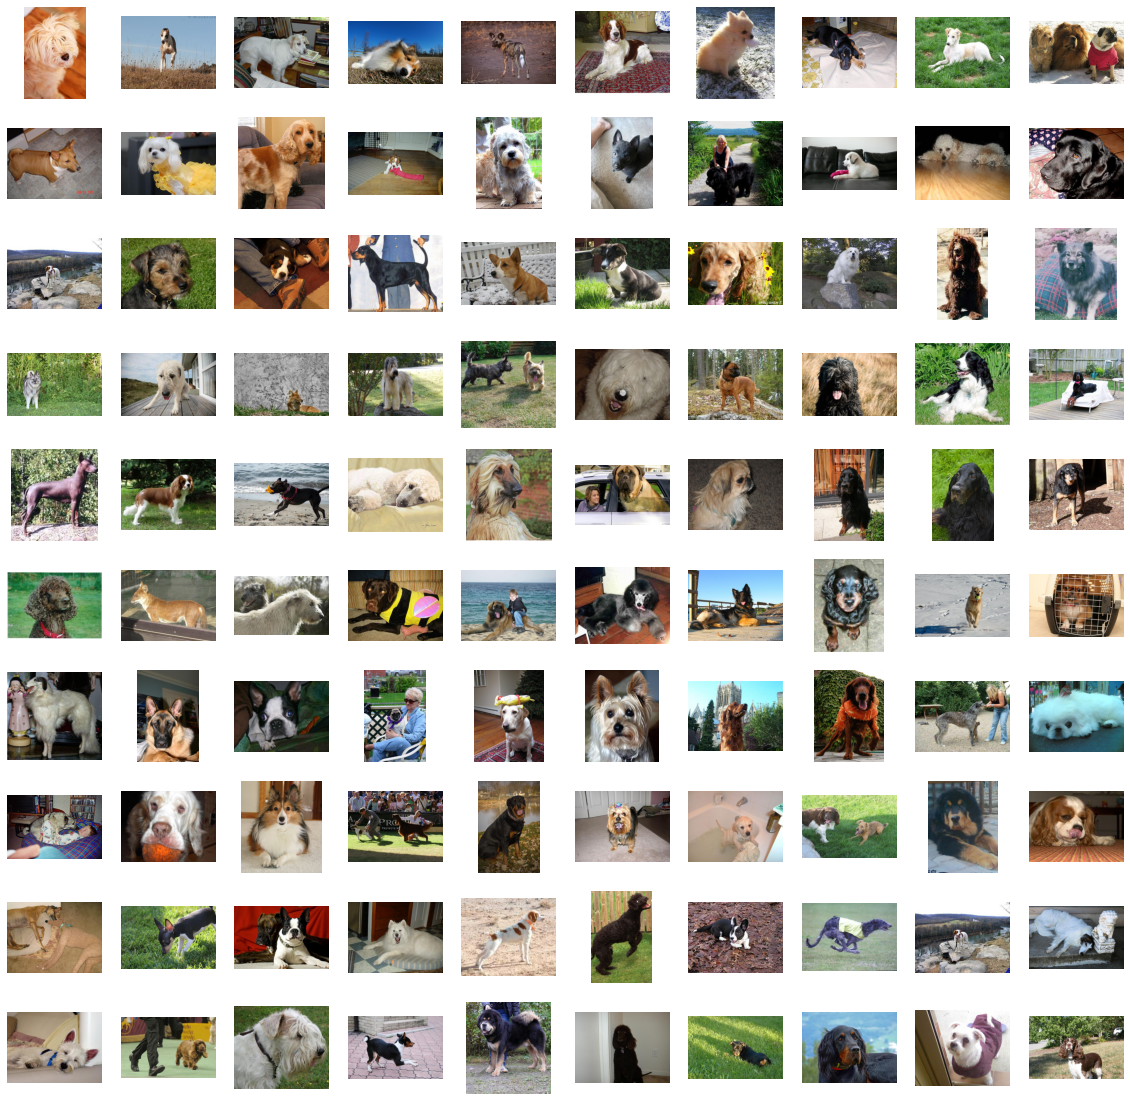

In [4]:
def show_images(img_paths):
    fig=plt.figure(figsize=(20, 20))
    index = np.random.randint(len(img_paths), size=100)
    for i in range(100):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        img = Image.open(img_paths[index[i]])
        plt.imshow(img)
    plt.show()
    
files = [f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)]
show_images(files)

Podemos obserar las siguientes características que pueden complicar el problema:

- Las imágenes son de **diferentes tamaños**.
- Hay **diferentes objetos en las imágenes**.

Vamos a crear un lista (`classes`) con el nombre de las razas de los perros que serán las clases en las que clasificarán los modelos que creemos:

In [5]:
classes = [f.split('/')[-1] for f in glob.glob("dog-dataset/dog-images/**")]
classes

['bluetick',
 'borzoi',
 'Norwegian_elkhound',
 'American_Staffordshire_terrier',
 'Irish_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Dandie_Dinmont',
 'Scotch_terrier',
 'soft-coated_wheaten_terrier',
 'golden_retriever',
 'Labrador_retriever',
 'Gordon_setter',
 'clumber',
 'cocker_spaniel',
 'groenendael',
 'briard',
 'Old_English_sheepdog',
 'German_shepherd',
 'Greater_Swiss_Mountain_dog',
 'Bernese_mountain_dog',
 'bull_mastiff',
 'Tibetan_mastiff',
 'chow',
 'keeshond',
 'Brabancon_griffon',
 'Pembroke',
 'Cardigan',
 'miniature_poodle',
 'Mexican_hairless',
 'toy_terrier',
 'bloodhound',
 'Sussex_spaniel',
 'Irish_water_spaniel',
 'Samoyed',
 'otterhound',
 'Shetland_sheepdog',
 'French_bulldog',
 'Australian_terrier',
 'Great_Pyrenees',
 'Maltese_dog',
 'whippet',
 'Boston_bull',
 'Irish_setter',
 'Rottweiler',
 'schipperke',
 'Leonberg',
 'Welsh_springer_spaniel',
 'Pomeranian',
 'Pekinese',
 'Irish_wolfhound',
 'Blenheim_spaniel',
 'basenji',
 'African_hunting_dog'

Vamos a mostrar una imagen aleatoria por cada clase:

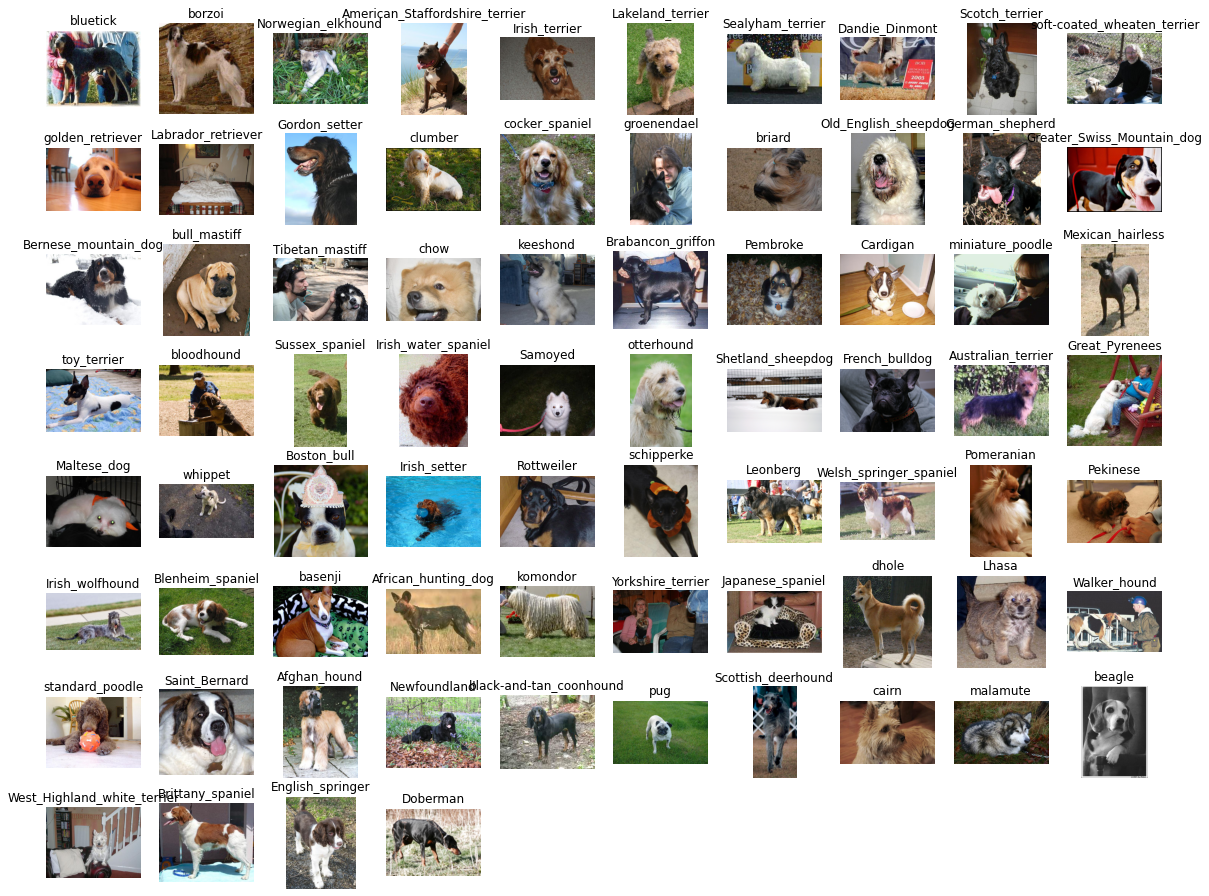

In [6]:
img_per_class = {}

for c in classes:
   files = [f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]
   index = np.random.randint(len(files))
   img_per_class[c] = files[index]

fig=plt.figure(figsize=(20, 20))
for i, (k, v) in enumerate(img_per_class.items()):
    fig.add_subplot(10, 10, i+1)
    plt.axis('off')
    img = Image.open(v)
    plt.title(k);
    plt.imshow(img)
plt.show()

Veamos si las clases están valanceadas:

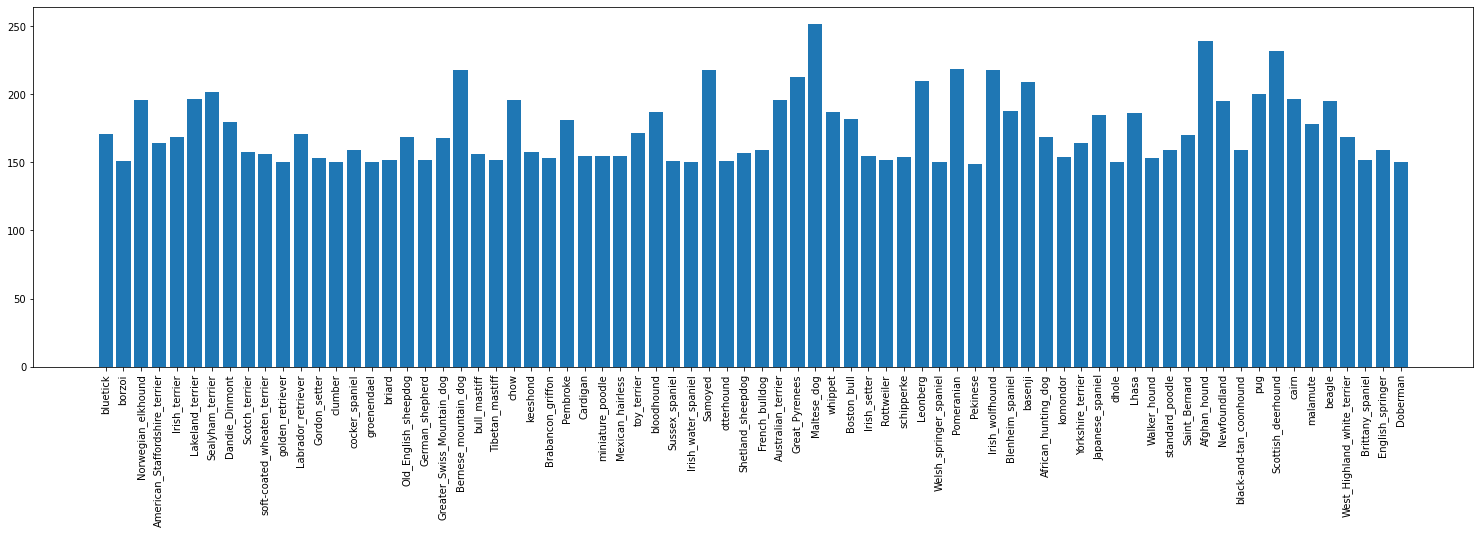

In [7]:
targets = [len([f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]) for c in classes]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,targets)
plt.xticks(rotation='vertical')
plt.show()

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section3"></a> 
## <font color="#00586D"> 3. Preprocesamiento de datos</font>
<br>


En esta sección vamos a cargar los datos creando los dataset para el conjunto de training, de validación y de test. En otras prácticas hemos visto como cargar con `tf.keras.utils.Sequence` y `tf.data.Dataset` batches de imágenes. En este caso, nos vamos a centrar en el segundo, ya que es más eficiente, sobre todo en Colab, como comentamos en la sección de Carga de datos masiva.

En este Capstone os vamos a dar una serie de funciones que permiten ejecutar los experimentos de forma más rápida para que no os tengáis que preocupar por la configuración de la base de datos.

In [8]:
def read_image(image_path, label):
    """
      Cargamos una imagen usando su ruta (path), la convertimos en tensor y la normalizamos
    """
    contents = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(contents, channels=3)
    img = tf.cast(img, tf.float64)
    img /= 255.0
    return img, label

def resize_image(img, label, target_size):
    """
      Redimensionamos una imagen
    """
    resized_img = tf.image.resize(img, target_size)
    return resized_img, label

def get_dataset(image_paths, image_labels, target_size, batch_size, prep_func=None):
    """
      - Generamos un objeto tf.data.Dataset para optimizar el entrenamiento desde los 
        paths de las imagenes
      - Aplicamos las funciones read_image y resize_image a las imagenes
      - Podemos usar una función prep_func si queremos hacer fine-tunning
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(read_image)
    dataset = dataset.map(lambda x, y: resize_image(x, y, target_size))  

    if prep_func != None:
        dataset = dataset.map(lambda x, y: (x*255.0, y))
        dataset = dataset.map(lambda x, y: (prep_func(x), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

Con estas funciones, podemos crear unos `tf.data.Dataset` que son óptimos a la hora de leer imágenes en memoria y ejecutar los batches y la forma de crearlos y ejecutarlos es la siguiente: 

```python
# definimos el img_size objetivo y el batch_size
img_size = (224,224,3)
batch_size = 32

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(images_train_paths, labels_train, img_size[0:-1], batch_size)

# ya solo nos queda llamar a fit con la base de datos
model.fit(train_dataset, epochs=10)
```

Así es como deberemos llamar al método en celdas sucesivas cuando queramos entrenar nuestras redes.

Aunque tenemos los csv con los conjuntos de `train`, `valid` y `test`, vamos generar las particiones nosotros mismos para ver cómo se hace y para asegurarnos que lo hacemos de forma correcta.


In [9]:
num_to_label = {i: c for i, c in enumerate(classes)}
label_to_num = {c: i for i, c in enumerate(classes)}
image_paths = np.array([f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])
image_labels =  np.array([label_to_num[f.split('/')[-2]] for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])

In [10]:
shuffler = np.random.permutation(len(image_paths))
image_paths = image_paths[shuffler]
image_labels = image_labels[shuffler]

# Train/valid/test split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(image_paths, image_labels, test_size=0.1, random_state=1234, stratify=image_labels)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=5678, stratify=y_train_valid)

print("Train: ", x_train.shape)
print("Valid: ", x_valid.shape)
print("Test: ", x_test.shape)

del x_train_valid, y_train_valid

Train:  (9280,)
Valid:  (2321,)
Test:  (1290,)


Una vez tenemos listas las particiones, ya solo tenemos que crear los datasets con las funciones proporcionadas.

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a> 
## <font color="#00586D"> 4. Experimento ejemplo</font>
<br>

Aquí os mostramos un ejemplo de experimento y evaluación de un modelo. Podéis basaros en este para los modelos que tenéis que crear vosotros. Además de las gráficas de train y validación, hay una celda que muestra la matriz de confusión de la clase y que deberéis utillizar en los ejercicios.

### <font color="#00586D"> Arquitectura y configuración de la red</font>

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa *Fully connected* con 1 neurona con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 2
* Tamaño del batch: 128

In [13]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [14]:
# Creamos nuestra red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="relu"),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 36000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 36001     
_________________________________________________________________
dense_1 (Dense)              (None, 74)                148       
Total params: 36,149
Trainable params: 36,149
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Entrenamos
history = model.fit(train_dataset, epochs=2, validation_data=valid_dataset)

Epoch 1/2
73/73 [==============================] - 52s 685ms/step - loss: 4.3038 - accuracy: 0.0158 - val_loss: 4.3023 - val_accuracy: 0.0198
Epoch 2/2
73/73 [==============================] - 55s 758ms/step - loss: 4.3020 - accuracy: 0.0187 - val_loss: 4.3009 - val_accuracy: 0.0198


In [17]:
# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 6s 558ms/step - loss: 4.3008 - accuracy: 0.0194


[4.300762176513672, 0.01937984488904476]

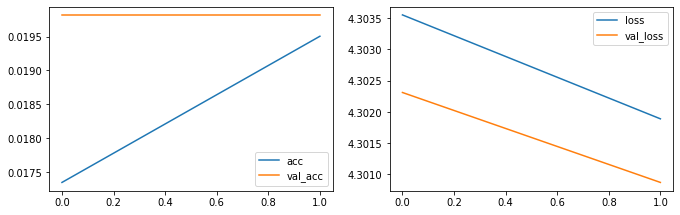

In [18]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

In [ ]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a> 
## <font color="#00586D"> 5. Creación de un modelo desde cero</font>
<br>


En esta sección se diseñará y entrenará una red convolucional siguiendo una estructura de tipo *VGG16* como las que vimos en clase. Una vez entrenada la red, tendrás que evaluar el resultado.

### <font color="#00586D"> Arquitectura y configuración de la red</font>

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [20]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [22]:
#Crear la red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=32,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=64,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 120, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 60, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              49153024  
_________________________________________________________________
dense_5 (Dense)              (None, 74)               

In [23]:
#configuración del entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 99s 1s/step - loss: 4.5069 - accuracy: 0.0221 - val_loss: 4.1013 - val_accuracy: 0.0427
Epoch 2/10
73/73 [==============================] - 64s 878ms/step - loss: 3.9613 - accuracy: 0.0750 - val_loss: 4.0863 - val_accuracy: 0.0586
Epoch 3/10
73/73 [==============================] - 58s 801ms/step - loss: 3.5016 - accuracy: 0.1663 - val_loss: 4.3847 - val_accuracy: 0.0664
Epoch 4/10
73/73 [==============================] - 62s 846ms/step - loss: 2.8464 - accuracy: 0.3007 - val_loss: 5.2217 - val_accuracy: 0.0577
Epoch 5/10
73/73 [==============================] - 64s 872ms/step - loss: 1.9449 - accuracy: 0.5112 - val_loss: 6.9303 - val_accuracy: 0.0569
Epoch 6/10
73/73 [==============================] - 62s 852ms/step - loss: 1.2541 - accuracy: 0.6826 - val_loss: 10.4239 - val_accuracy: 0.0607
Epoch 7/10
73/73 [==============================] - 65s 891ms/step - loss: 0.7982 - accuracy: 0.7992 - val_loss: 8.9672 - val_accuracy: 0.0543
E

In [25]:
# Evaluación con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 9s 781ms/step - loss: 10.6230 - accuracy: 0.0558


[10.6229829788208, 0.055813953280448914]

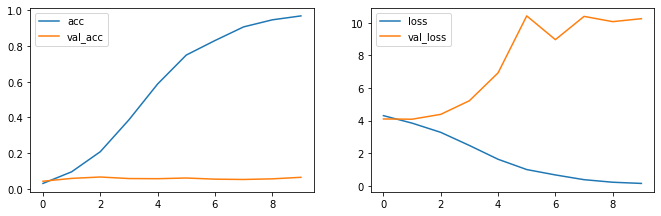

In [26]:
# Visualización la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

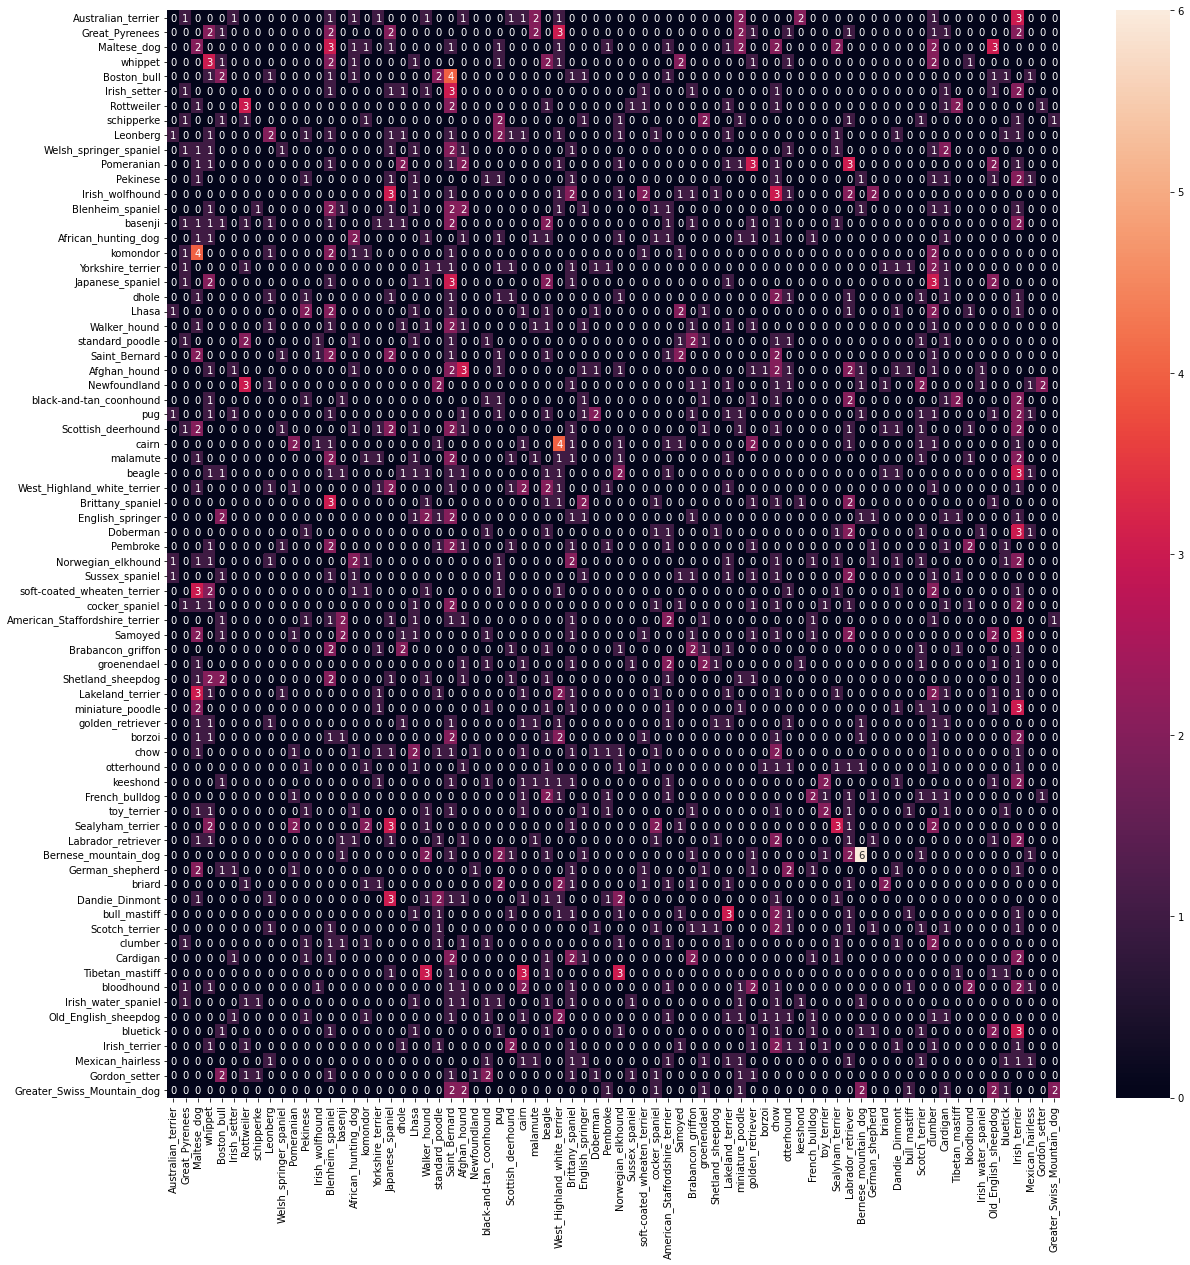

In [27]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Podemos observar que los resultados han mejorado notablemente respecto al experimento anterior. En el caso del primer modelo entrenado la red era demasiado simple para poder ser un buen clasificador y clasificaba todas las imágenes como maltese_dog que es la clase de perro más representada en la base de datos. En este caso la red es más compleja y permite al clasificador predecir otros tipos de raza de perro. Pero se puede observar un claro sobreajuste a los datos de entrenamiento, observable en las gráficas de perdida y precisión donde en cada epoch los valores mejoran notablemente para el conjunto de entrenamiento pero en el caso del conjunto de validación estos se encuentran estancados. Parece que el aumento del número de capas, la adición de capas convolucionales y el aumento de los epoch no ha sido suficiente para obtener un buen modelo. Habría que probar a añadir más capas aumentando la capacidad del modelo para encontrar patrones y añadir capas de 'Dropout' para luchar en contra del sobreajuste.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a> 
## <font color="#00586D"> 6. Ajuste de hiperparámetros</font>
<br>




En esta sección vamos a intentar mejorar la red anterior con capas `Dropout` y cambiando los hiperparámetros.

La arquitectura de la red es la siguiente:

* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa *Dropout* con valor 0.2.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [28]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [29]:
#Crear la red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=32,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=64,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=64,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 120, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 60, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 60, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 30, 64)        102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 15, 64)       

In [30]:
#configuración del entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 52s 700ms/step - loss: 4.3308 - accuracy: 0.0149 - val_loss: 4.2952 - val_accuracy: 0.0215
Epoch 2/10
73/73 [==============================] - 57s 787ms/step - loss: 4.2151 - accuracy: 0.0307 - val_loss: 4.1626 - val_accuracy: 0.0422
Epoch 3/10
73/73 [==============================] - 52s 714ms/step - loss: 4.0716 - accuracy: 0.0485 - val_loss: 4.0544 - val_accuracy: 0.0612
Epoch 4/10
73/73 [==============================] - 52s 719ms/step - loss: 3.9483 - accuracy: 0.0695 - val_loss: 3.9498 - val_accuracy: 0.0689
Epoch 5/10
73/73 [==============================] - 52s 719ms/step - loss: 3.7939 - accuracy: 0.0997 - val_loss: 3.8546 - val_accuracy: 0.0793
Epoch 6/10
73/73 [==============================] - 63s 866ms/step - loss: 3.6476 - accuracy: 0.1143 - val_loss: 3.8435 - val_accuracy: 0.0888
Epoch 7/10
73/73 [==============================] - 65s 893ms/step - loss: 3.4033 - accuracy: 0.1680 - val_loss: 3.8774 - val_accuracy: 0.0883

In [32]:
# Evaluación con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 6s 514ms/step - loss: 4.5038 - accuracy: 0.0806


[4.503839492797852, 0.08062015473842621]

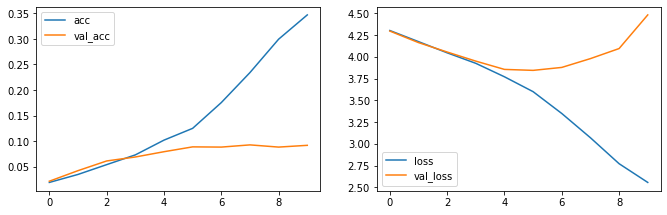

In [33]:
# Visualización la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

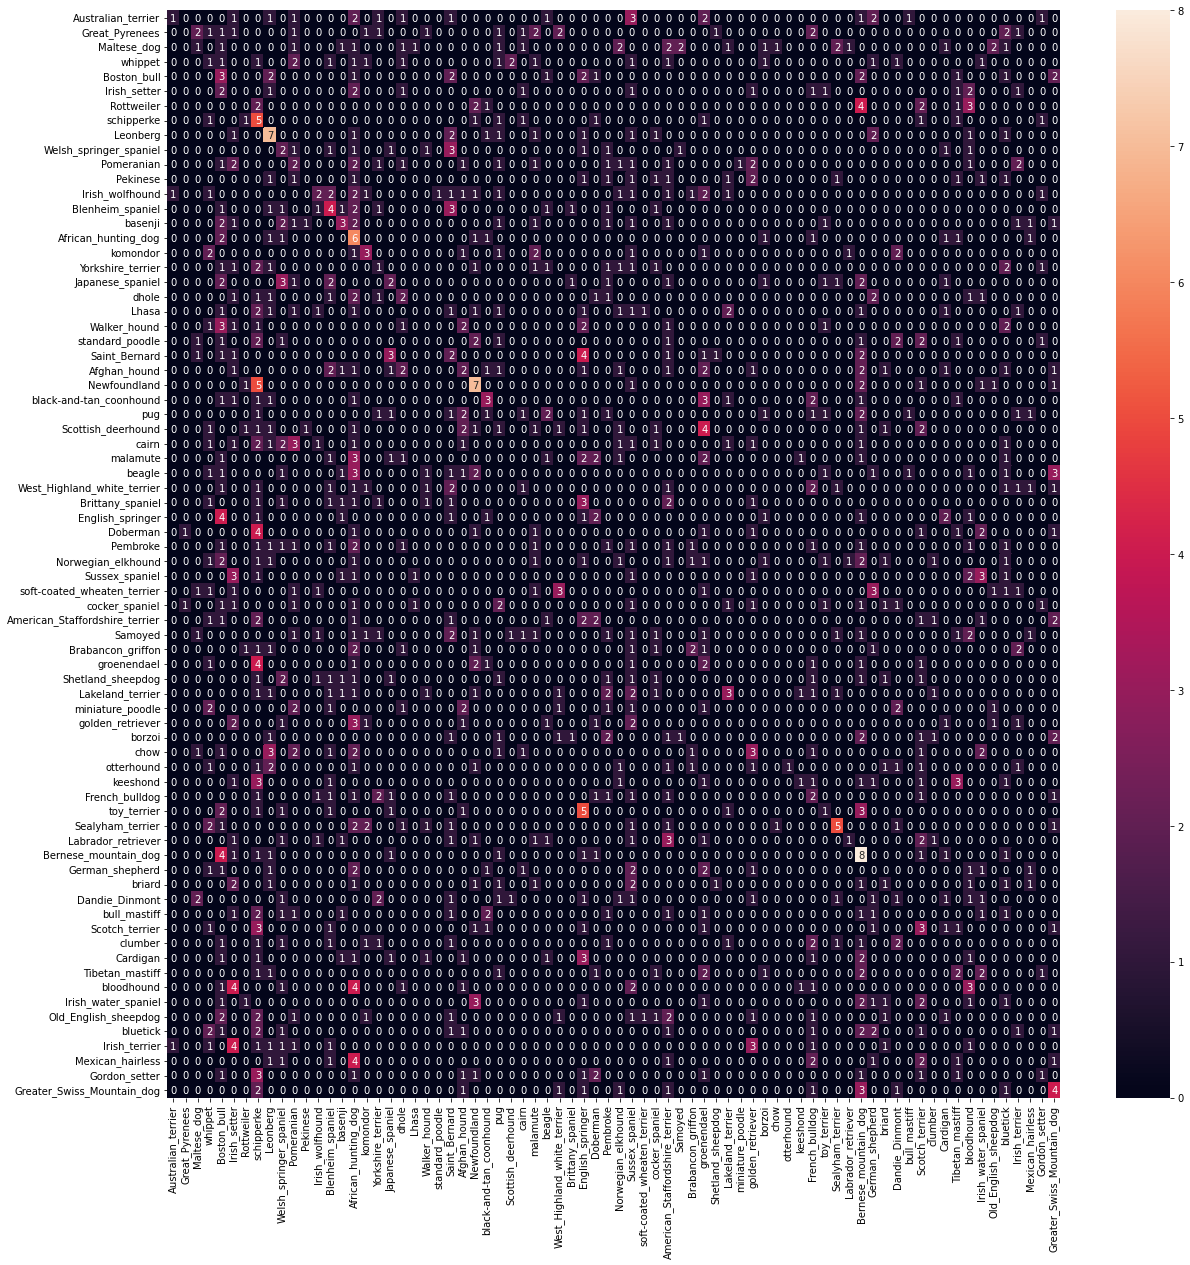

In [34]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Con esta red podemos observar que al fin sí que consigue aprender de los datos y mejora ligeramente los valores de los modelos anteriores, viendo además que con los primeros epoch los valores de precisión y pérdida van mejorando con cada epoch. Pero, a partir del 4 epoch vemos que el modelo comienza a sobreajustarse a los datos de entrenamiento, el valor de precisión respecto al conjunto de validación se estanca y los valores de pérdida son cada vez peores. Esto demuestra que seguimos teniendo un gran problema de sobreajuste y que si queremos utilizar este modelo habría que reentrenarlo pero con menor número de epochs.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a> 
## <font color="#00586D"> 7. Modelos pre-entrenados (fine-tunning)</font>
<br>




En esta sección tendréis que utilizar los conocimientos sobre los modelos pre-entrenados y _fine-tunning_, donde tendréis que adaptar una red pre-entrenada a nuestro problema. El modelo pre-entreando que tendréis que usar es _Inception_, cuya versión 3 es de las más utilizadas en _Fine-tuning_ por sus buenos resultados.

### <font color="#00586D"> Inception</font>


La configuración de la red a cargar es la siguiente:

* Tamaño de entrada será `(299, 299, 3)`.
* Elegiremos la configuración `include_top = false` y el `pooling = 'avg'`
* Añadiremos una capa de _Dropout_ de 0.5
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Epochs: 10
* Tamaño del batch: 128

In [39]:
# Cargamos datos con las funciones de generación de dataset
# esta vez usams la funcion de preprocesamiento de inception
img_size = (299,299,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128, tf.keras.applications.inception_v3.preprocess_input)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128, tf.keras.applications.inception_v3.preprocess_input)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128, tf.keras.applications.inception_v3.preprocess_input)

In [40]:
# red
model=tf.keras.applications.inception_v3.InceptionV3(
        include_top=False, pooling='avg',
        classifier_activation='softmax'
)

87916544/87910968 [==============================] - 1s 0us/step


In [41]:
#configuración del entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 171s 2s/step - loss: 4.1055 - accuracy: 0.2273 - val_loss: 14.0688 - val_accuracy: 0.0000e+00
Epoch 2/10
73/73 [==============================] - 138s 2s/step - loss: 2.8256 - accuracy: 0.2963 - val_loss: 16.2193 - val_accuracy: 0.0151
Epoch 3/10
73/73 [==============================] - 138s 2s/step - loss: 3.1471 - accuracy: 0.2344 - val_loss: 10.4261 - val_accuracy: 0.0250
Epoch 4/10
73/73 [==============================] - 140s 2s/step - loss: 3.5932 - accuracy: 0.1536 - val_loss: 11.3539 - val_accuracy: 0.0108
Epoch 5/10
73/73 [==============================] - 139s 2s/step - loss: 3.5411 - accuracy: 0.1423 - val_loss: 13.7234 - val_accuracy: 0.0013
Epoch 6/10
73/73 [==============================] - 140s 2s/step - loss: 3.4687 - accuracy: 0.1482 - val_loss: 9.5024 - val_accuracy: 0.0457
Epoch 7/10
73/73 [==============================] - 140s 2s/step - loss: 2.7961 - accuracy: 0.2728 - val_loss: 3.7243 - val_accuracy: 0.2357
Epoc

In [ ]:
# Evaluación con el conjunto de test
model.evaluate(test_dataset)

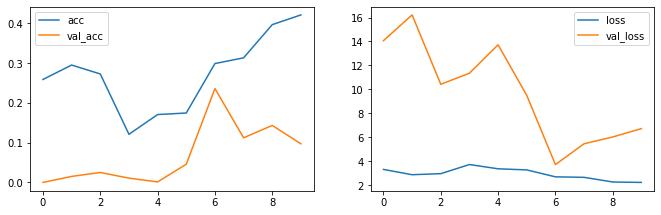

In [43]:
# Visualización la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Podemos observar que con este modelo sí que somos capaces de obtener mejores resultados y que el modelo obtenga cada vez mejores valores de precisión y perdida conforme van avanzando los epochs. Pero, a partir del epoch número 6, los valores de precisión para el conjunto de validación, así como los valores de pérdida comienzan a empeorar en cada epoch, mostrando un claro sobreajuste y separando los valores obtenidos en el conjunto de validación y entrenamiento. De ahí que si queremos obtener un buen rendimiento habría que volver a entrenar el modelo pero sólamente con 6 epoch.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a> 
## <font color="#00586D"> 8. Data augmentation</font>
<br>





En este apartado se deberán aplicar algunas de las funciones de preprocesamiento vistas en la clase de _data augmentation_. Nos centraremos en *data augmentation* estocástico sobre la red obtenida en el apartado de modelos desde 0 y tratar de mejorar el rendimiento. Vamos a utilizar una o varias de las siguientes modificaciones:

  *    Flip horizontal
  *    Flip vertical
  *    Contraste

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [11]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [12]:
#Crear la red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=32,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Conv2D(input_shape=img_size,filters=64,kernel_size=(5,5),padding="same", activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 100, 120, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 100, 120, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 100, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 120, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 60, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 30, 64)        0

In [13]:
#configuración del entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 2339s 32s/step - loss: 4.3686 - accuracy: 0.0223 - val_loss: 4.2316 - val_accuracy: 0.0349
Epoch 2/10
73/73 [==============================] - 96s 1s/step - loss: 4.1663 - accuracy: 0.0364 - val_loss: 4.0925 - val_accuracy: 0.0461
Epoch 3/10
73/73 [==============================] - 96s 1s/step - loss: 4.0628 - accuracy: 0.0497 - val_loss: 4.0582 - val_accuracy: 0.0461
Epoch 4/10
73/73 [==============================] - 96s 1s/step - loss: 3.9572 - accuracy: 0.0684 - val_loss: 4.0007 - val_accuracy: 0.0564
Epoch 5/10
73/73 [==============================] - 96s 1s/step - loss: 3.7886 - accuracy: 0.1003 - val_loss: 3.9807 - val_accuracy: 0.0590
Epoch 6/10
73/73 [==============================] - 96s 1s/step - loss: 3.6469 - accuracy: 0.1321 - val_loss: 3.9411 - val_accuracy: 0.0685
Epoch 7/10
73/73 [==============================] - 96s 1s/step - loss: 3.4854 - accuracy: 0.1673 - val_loss: 3.9714 - val_accuracy: 0.0741
Epoch 8/10
73/73 

In [16]:
# Evaluación con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 187s 19s/step - loss: 4.4534 - accuracy: 0.0705


[4.453392028808594, 0.07054263353347778]

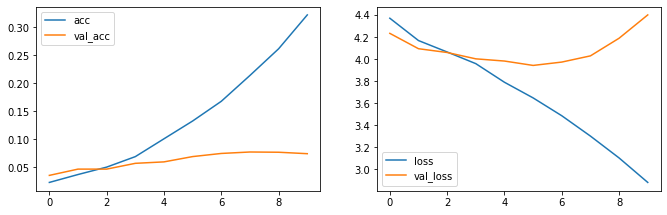

In [17]:
# Visualización la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

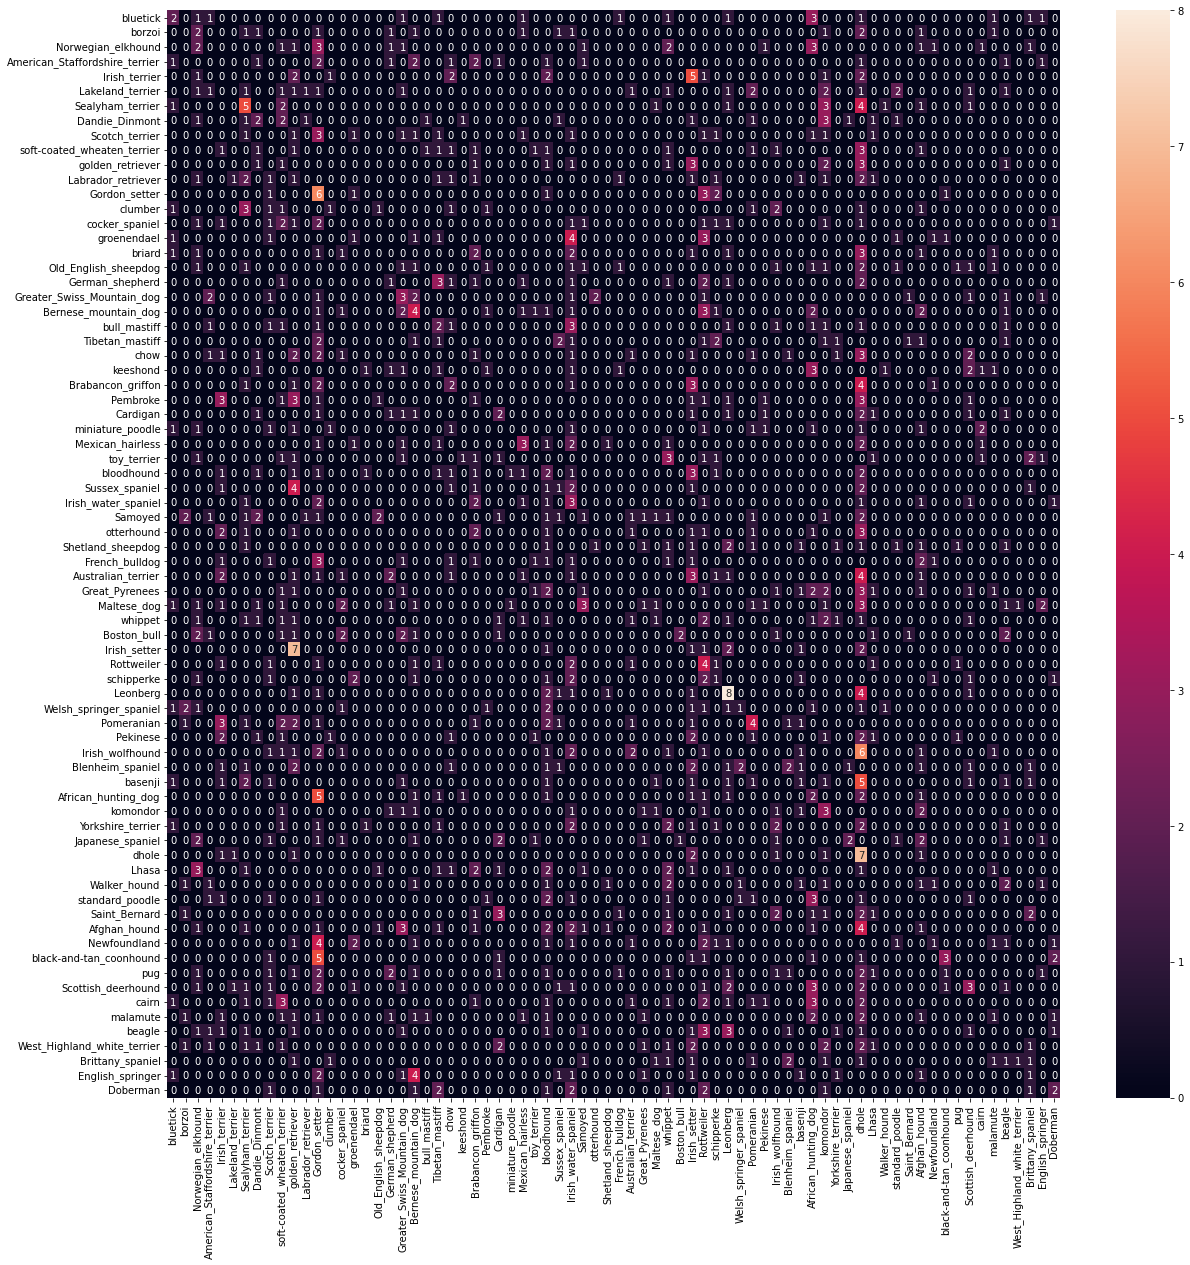

In [18]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Los resultados son similares a los anteriores aunque esta vez un poco peores, los resultados muestran un claro sobreajuste y los valores de perdida y precisión no mejoran con los epoch, tal vez debido a que la red no es lo suficientemente compleja como para poder funcionar como clasificador.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a> 
## <font color="#00586D"> AutoKeras (opcional) </font>
<br>


En este experimentos vamos a utilizar AutoKeras para realizar el entrenamiento. Nos centraremos en utilizar el bloque `ImageClassifier` a alto nivel, con tan solo un `max_trials` de 1 ya que será un experimento muy costoso computacionalmente.

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Bloque `ImageClassifier` con la siguiente configuración:
  - `max_trials` de 1
  - En `metrics` incluye el `accuracy`
  - `overwrite` a `True`

  En este tipo de bloque puedes pasarle al parámetro `x` un `tf.data.Dataset` al igual que al parámetros `validation_data`.

Configuración del entrenamiento:
* Epochs: 10
* Callbacks: usa `EarlyStopping` con un `patience` de 2 para terminar antes el entrenamiento si el modelo deja de aprender.

In [ ]:
# Cargamos datos con las funciones de generación de dataset


In [ ]:
# COMPLETAR:
#   - Crear la red
#   - Entrena la red
#   - Evalúa la red

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Completar aquí`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="sectionopt"></a> 
## <font color="#00586D"> Conclusión</font>
<br>


Una vez realizado todos los experimentos anteriores, ¿qué modelo elegirías para desplegar en producción? ¿Por qué? 

Explica en breves palabras qué modelo eligirías para desplegar en producción y porqué. Compara cada experimento y extráe tus propias conclusiones.

---

`Todos los modelos plantean problemas como la falta de precisión o elevado sobreajuste así que habría que seguir probando configuraciones como reajustar hiperparámetros, añadir capas de Dropout en los casos que no las hubiera y seguramente intentar añadir capas que aumenten la complejidad de la red y la capacidad para detectar patrones. Entre los modelos generados, el de Finetunning a partir de un modelo preentrenado de inception parece ser el que mejores resultados ha obtenido, tal vez sería este el que se utilizaría en producción aunque seguramente se podría mejorar si se intentaran realizar cambios como los anteriormente mencionados. Para usarlo en producción habría que reentrenarlo con menos epoch para evitar el sobreajuste que se había producido en los epoch finales durante el entrenamiento.`



---


<div style="text-align: center; font-size: 24px;">
    <img src="https://drive.google.com/uc?id=1xHx0M9NUXi4YcDyi1BwuUE6y0TK0kHfs">
</div>

####  ¡Si has llegado hasta aquí deberías estar super orgullos@!  Ya puedes relajar tus neuronas, les has dado mucho trabajo



<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>